# Chicken Disease Classification

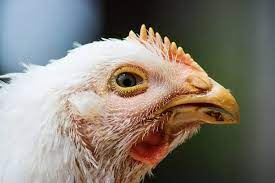

## Import all the Dependencies

In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import numpy as np

## Set all the Constants

In [2]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=50

# Import data into tensorflow dataset object

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    r"D:\Capstone_2_Project\Dataset Chicken\poultry_diseases",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 4160 files belonging to 2 classes.


In [4]:
class_names = dataset.class_names
class_names

['Coccidiosis', 'Healthy']

In [5]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[0 0 1 0 1 0 1 1 1 1 1 0 0 0 1 1 1 0 1 1 1 1 0 0 1 0 0 1 0 0 1 0]


***As you can see above, each element in the dataset is a tuple. First element is a batch of 32 elements of images. Second element is a batch of 32 elements of class labels***

# Visualize some of the images from our dataset

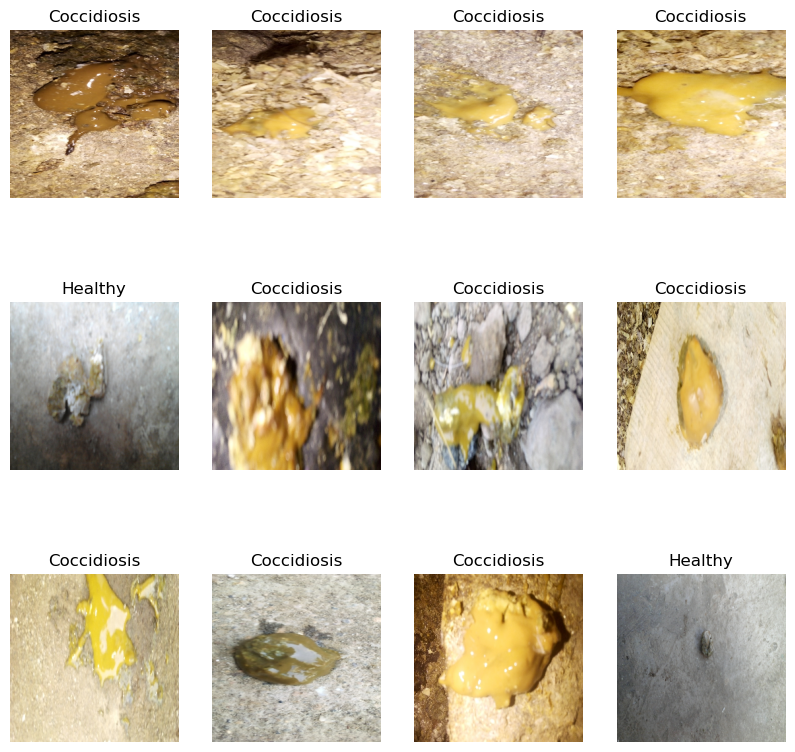

In [6]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

## Function to Split Dataset
***Dataset should be bifurcated into 3 subsets, namely:***

***1) Training: Dataset to be used while training***

***2) Validation: Dataset to be tested against while training***
***3) Test: Dataset to be tested against after we trained a model***


In [7]:
len(dataset)

130

In [8]:
train_size = 0.8
len(dataset)*train_size

104.0

In [9]:
train_ds = dataset.take(104)
len(train_ds)

104

In [10]:
temp = dataset.skip(104)
len(temp)

26

In [11]:
val_size=0.5
len(temp)*val_size

13.0

In [12]:
val_ds = temp.take(13)
len(val_ds)

13

In [13]:
test_ds = temp.skip(13)
len(test_ds)

13

In [14]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [15]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [16]:
len(train_ds)

104

In [17]:
len(val_ds)

13

In [18]:
len(test_ds)

13

# Cache, Shuffle, and Prefetch the Dataset

In [19]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

# Building the Model

***Creating a Layer for Resizing and Normalization***

***Before we feed our images to network, we should be resizing it to the desired size. Moreover, to improve model performance, we should normalize the image pixel value (keeping them in range 0 and 1 by dividing by 256). This should happen while training as well as inference. Hence we can add that as a layer in our Sequential Model.***

***You might be thinking why do we need to resize (256,256) image to again (256,256). You are right we don't need to but this will be useful when we are done with the training and start using the model for predictions. At that time somone can supply an image that is not (256,256) and this layer will resize it***



In [20]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

# Data Augmentation

In [21]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

# Applying Data Augmentation to Train Dataset

In [22]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

# Model Architecture

***We use a CNN coupled with a Softmax activation in the output layer. We also add the initial layers for resizing, normalization and Data Augmentation.***

In [23]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 2

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(64, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(32, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [24]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 64)        1792      
                                                                 
 max_pooling2d (MaxPooling2  (32, 127, 127, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (32, 60, 60, 64)         

# Compiling the Model

In [25]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [26]:
# Training Model on the train dataset
history = model.fit(
    train_ds,
    batch_size=32,
    validation_data=val_ds,
    verbose=1,
    epochs=50,
)

Epoch 1/50


104/104 [==============================] - 348s 3s/step - loss: 0.2846 - accuracy: 0.8717 - val_loss: 0.0840 - val_accuracy: 0.9688
Epoch 2/50
104/104 [==============================] - 264s 3s/step - loss: 0.0843 - accuracy: 0.9718 - val_loss: 0.0649 - val_accuracy: 0.9760
Epoch 3/50
104/104 [==============================] - 261s 3s/step - loss: 0.1051 - accuracy: 0.9678 - val_loss: 0.0894 - val_accuracy: 0.9688
Epoch 4/50
104/104 [==============================] - 258s 2s/step - loss: 0.0740 - accuracy: 0.9748 - val_loss: 0.0736 - val_accuracy: 0.9808
Epoch 5/50
104/104 [==============================] - 260s 2s/step - loss: 0.0894 - accuracy: 0.9709 - val_loss: 0.0550 - val_accuracy: 0.9784
Epoch 6/50
104/104 [==============================] - 263s 3s/step - loss: 0.0578 - accuracy: 0.9796 - val_loss: 0.0531 - val_accuracy: 0.9808
Epoch 7/50
104/104 [==============================] - 260s 2s/step - loss: 0.0579 - accuracy: 0.9808 - val_loss: 0.0596 - val_accuracy: 0.97

In [27]:
scores = model.evaluate(test_ds)

13/13 [==============================] - 57s 571ms/step - loss: 0.0598 - accuracy: 0.9808


In [28]:
scores

[0.05975968390703201, 0.9807692170143127]

# Plotting the Accuracy and Loss Curves

In [29]:
history

In [30]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 104}

In [31]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [32]:
type(history.history['loss'])

list

In [33]:
len(history.history['loss'])

50

In [34]:
history.history['loss'][:5] # show loss for first 5 epochs

[0.28460991382598877,
 0.0842716172337532,
 0.10507318377494812,
 0.07395704090595245,
 0.08935283124446869]

In [35]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

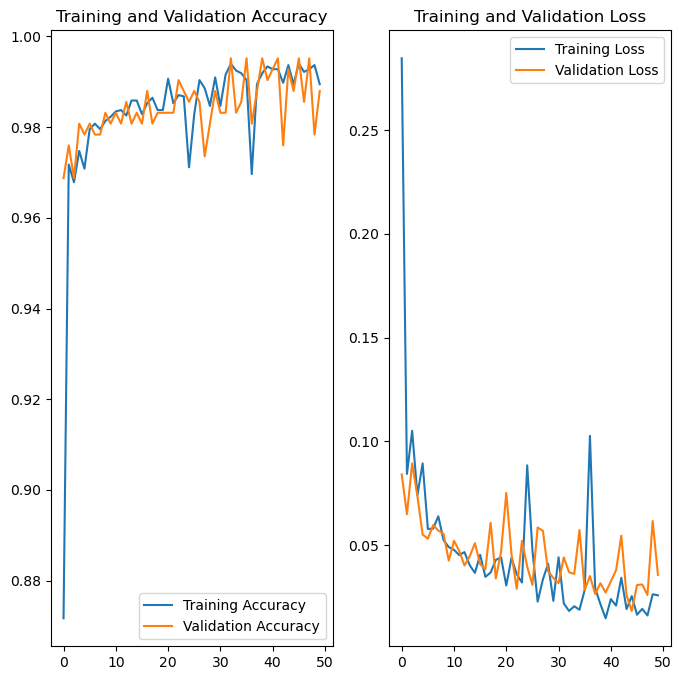

In [36]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [37]:
# Performace Evaluation

import pandas as pd
import seaborn as sns

record_df = pd.DataFrame(history.history)
record_df

loss  accuracy  val_loss  val_accuracy
0   0.284610  0.871695  0.084050      0.968750
1   0.084272  0.971755  0.064885      0.975962
2   0.105073  0.967849  0.089375      0.968750
3   0.073957  0.974760  0.073619      0.980769
4   0.089353  0.970853  0.055031      0.978365
5   0.057769  0.979567  0.053072      0.980769
6   0.057882  0.980769  0.059554      0.978365
7   0.063853  0.979567  0.057007      0.978365
8   0.052359  0.981370  0.055366      0.983173
9   0.049019  0.982272  0.042469      0.980769
10  0.047666  0.983474  0.052028      0.983173
11  0.045175  0.983774  0.047190      0.980769
12  0.046595  0.982572  0.040153      0.985577
13  0.040303  0.985877  0.044493      0.980769
14  0.036577  0.985877  0.050881      0.983173
15  0.045265  0.982873  0.040806      0.980769
16  0.034638  0.985276  0.038272      0.987981
17  0.036758  0.986478  0.060709      0.980769
18  0.042812  0.983774  0.033919      0.983173
19  0.044042  0.983774  0.046775      0.983173
20  0.030472  0.990685  0.075089      0.983173
21  0.043828  0.985276  0.045503      0.983173
22  0.035925  0.987079  0.028895      0.990385
23  0.031909  0.986779  0.052029      0.987981
24  0.088408  0.971154  0.039574      0.985577
25  0.047418  0.982873  0.030784      0.987981
26  0.022714  0.990385  0.058462      0.985577
27  0.033393  0.988582  0.056859      0.973558
28  0.041033  0.984675  0.037375      0.980769
29  0.023087  0.990986  0.034107      0.987981
30  0.044081  0.984675  0.031618      0.983173
31  0.021855  0.991587  0.044057      0.983173
32  0.018222  0.993990  0.036890      0.995192
33  0.020489  0.992488  0.036073      0.983173
34  0.018803  0.991887  0.057248      0.985577
35  0.028368  0.990385  0.028350      0.995192
36  0.102611  0.969651  0.035046      0.980769
37  0.029118  0.989483  0.026403      0.987981
38  0.021559  0.991887  0.031589      0.995192
39  0.014694  0.993389  0.027095      0.990385
40  0.023930  0.992788  0.032489      0.992788
41  0.020796  0.992788  0.037852      0.995192
42  0.034235  0.989784  0.054512      0.975962
43  0.019163  0.993690  0.025798      0.992788
44  0.025388  0.989483  0.018188      0.987981
45  0.016406  0.993990  0.030690      0.995192
46  0.019233  0.992188  0.031007      0.985577
47  0.016043  0.992788  0.025929      0.995192
48  0.026274  0.993690  0.061593      0.978365
49  0.025732  0.989483  0.035629      0.987981

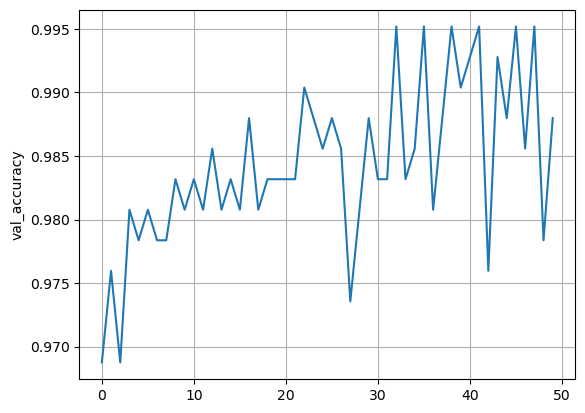

In [38]:
sns.lineplot(x = record_df.index, y = record_df['val_accuracy'])
plt.grid()

# Run prediction on a sample image

first image to predict
actual label: Healthy
1/1 [==============================] - 1s 880ms/step
predicted label: Healthy


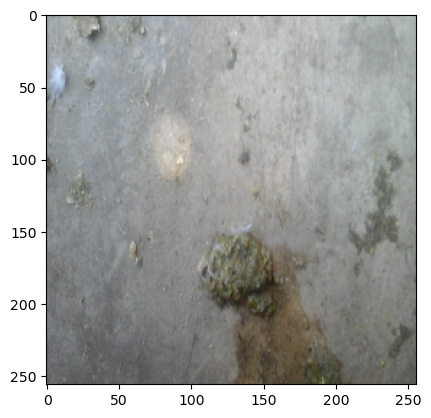

In [39]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

# Write a function for inference

In [40]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

### Now run inference on few sample images

1/1 [==============================] - 0s 63ms/step


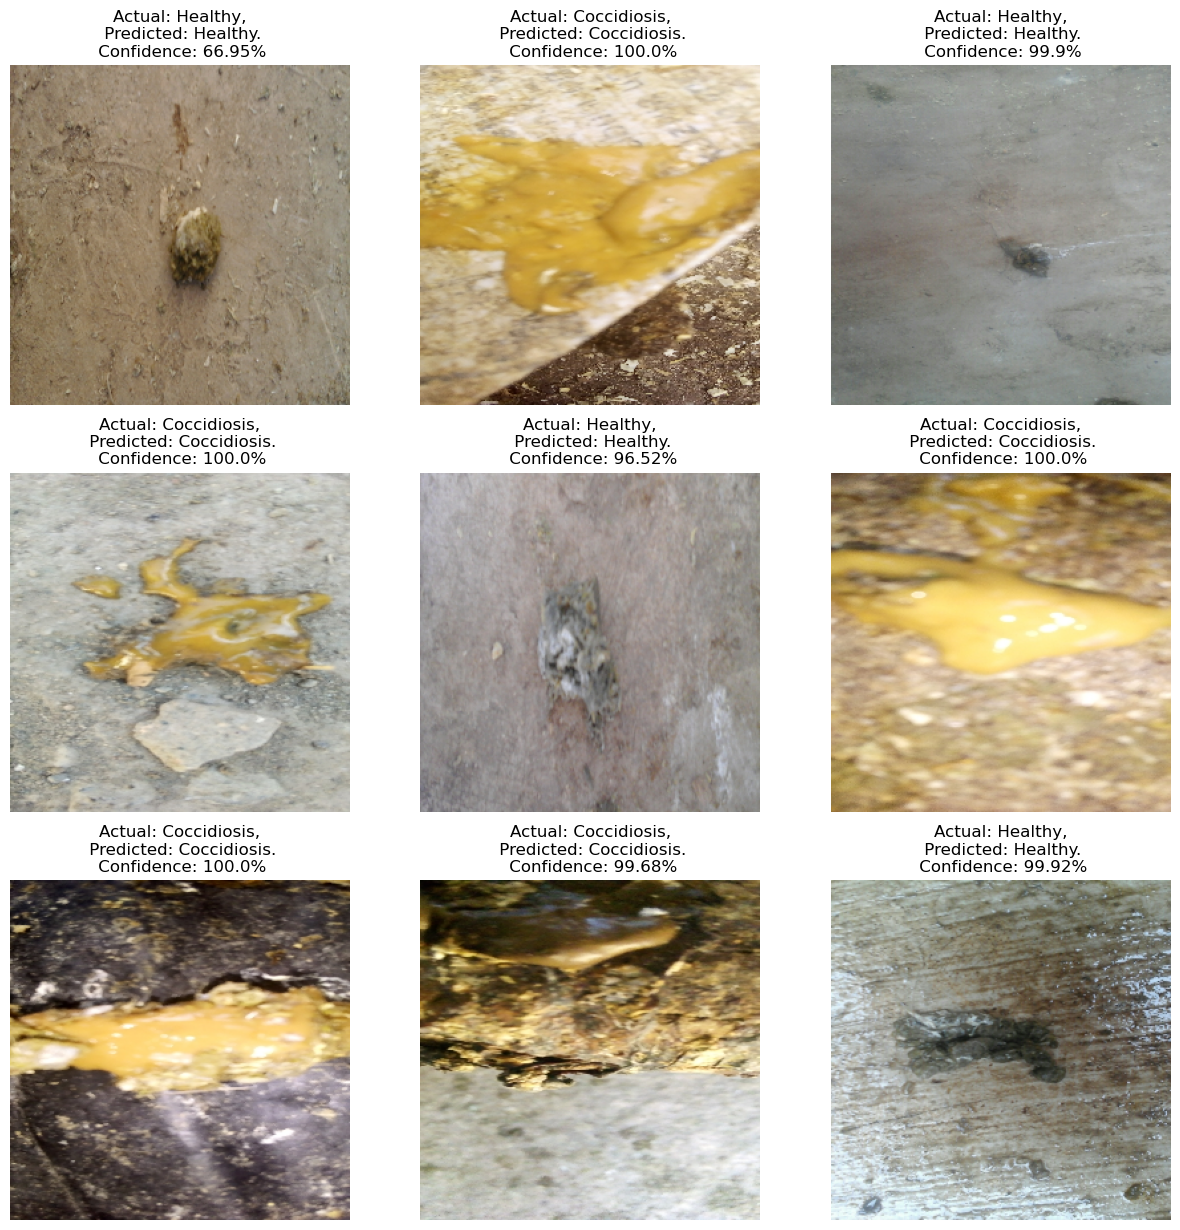

In [41]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

# Saving the Model

In [42]:
model.save(" Chicken_disease.h5")

C:\Users\Nikhil Nandugade\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# predict on one image

In [49]:
from tensorflow import keras
from tensorflow.keras.preprocessing import image

# Check our folder and import the model with best validation accuracy
loaded_best_model = keras.models.load_model(r"C:\Users\Nikhil Nandugade\Desktop\New Python\ Checken.h5")

# Custom function to predict label for the image
def predict(img_path):
    # Load the image from file path
    img = image.load_img(img_path, target_size=(300, 300))
    
    # Convert the image to a numpy array
    img = image.img_to_array(img)
    
    # Scaling the Image Array values between 0 and 1
    img = img / 255.0

    # Plotting the Loaded Image
    plt.title("Loaded Image")
    plt.axis('off')
    plt.imshow(img.squeeze())
    plt.show()

    # Get the Predicted Label for the loaded Image
    p = model.predict(img[np.newaxis, ...])

    # Label array
    labels = {0: 'Coccidiosis', 1: 'Healthy'}

    print("\n\nMaximum Probability: ", np.max(p[0], axis=-1))
    predicted_class = labels[np.argmax(p[0], axis=-1)]
    print("Classified:", predicted_class, "\n\n")

    classes = []
    prob = []
    print("\n-------------------Individual Probability--------------------------------\n")

    for i, j in enumerate(p[0], 0):
        print(labels[i].upper(), ':', round(j * 100, 2), '%')
        classes.append(labels[i])
        prob.append(round(j * 100, 2))

    def plot_bar_x():
        # this is for plotting purpose
        index = np.arange(len(classes))
        plt.bar(index, prob)
        plt.xlabel('Labels', fontsize=8)
        plt.ylabel('Probability', fontsize=8)
        plt.xticks(index, classes, fontsize=8, rotation=20)
        plt.title('Probability for loaded image')
        plt.show()

    plot_bar_x()

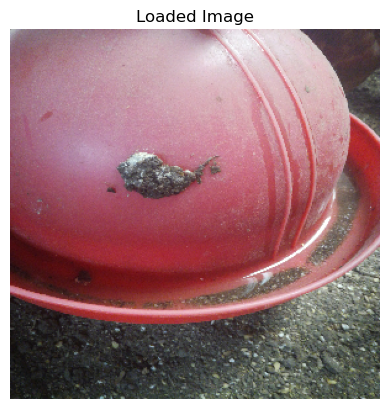

1/1 [==============================] - 0s 471ms/step


Maximum Probability:  0.9999107
Classified: Healthy 



-------------------Individual Probability--------------------------------

COCCIDIOSIS : 0.01 %
HEALTHY : 99.99 %


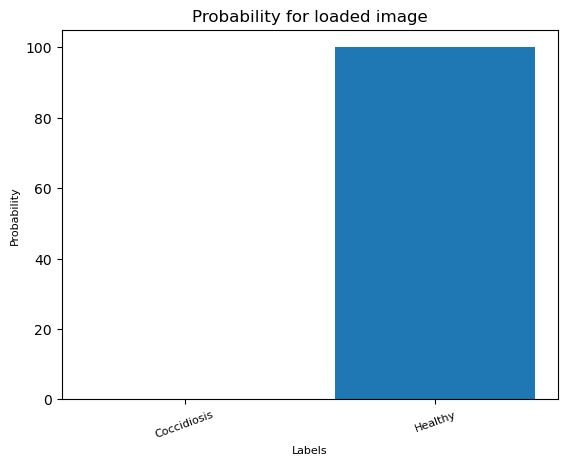

In [50]:
predict(r"D:\Capstone_2_Project\Dataset Chicken\poultry_diseases\Healthy\healthy.17.jpg")

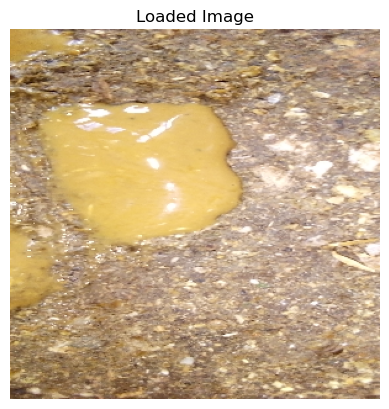

1/1 [==============================] - 0s 62ms/step


Maximum Probability:  0.9999083
Classified: Coccidiosis 



-------------------Individual Probability--------------------------------

HEALTHY : 0.01 %
COCCIDIOSIS : 99.99 %


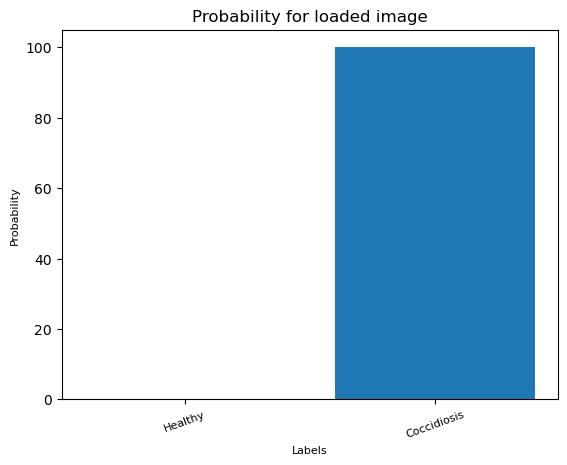

In [54]:
predict(r"D:\Capstone_2_Project\Dataset Chicken\poultry_diseases\Coccidiosis\cocci.13.jpg")

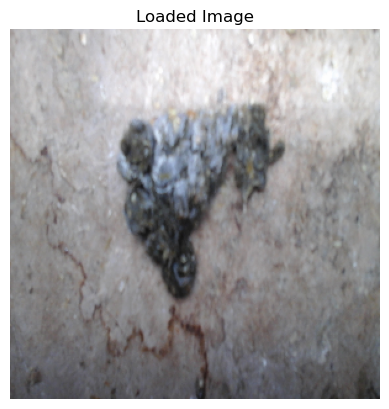

1/1 [==============================] - 0s 69ms/step


Maximum Probability:  0.9999112
Classified: Healthy 



-------------------Individual Probability--------------------------------

COCCIDIOSIS : 0.01 %
HEALTHY : 99.99 %


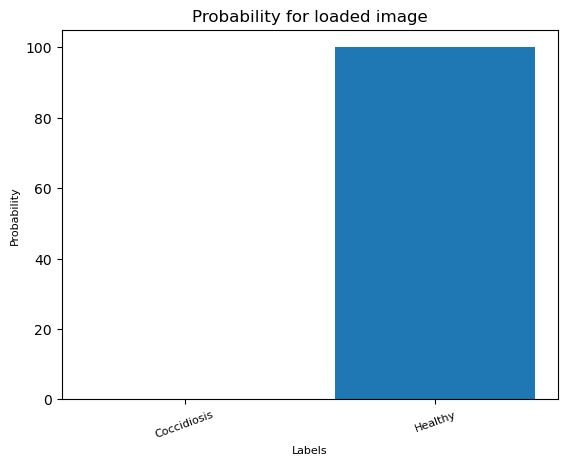

In [51]:
predict(r"D:\Capstone_2_Project\Dataset Chicken\poultry_diseases\Healthy\healthy.16.jpg")

# Deployment

In [55]:
from flask import Flask, request, jsonify
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import load_model
import numpy as np
import cv2

app = Flask('Chicken Disease Prediction')

# Load the model
model = load_model(r"C:\Users\Nikhil Nandugade\Desktop\New Python\ Chicken_disease.h5")

# Class names
class_names = ['class_1', 'class_2']

# Function to preprocess image
def preprocess_image(image):
    image = cv2.resize(image, (256, 256))
    image = image.astype("float") / 255.0
    image = img_to_array(image)
    image = np.expand_dims(image, axis=0)
    return image

# Route for prediction
@app.route('/predict', methods=['POST'])
def predict():
    data = {}
    if request.method == 'POST':
        file = request.files['file']
        if file:
            # Read image
            image = cv2.imdecode(np.fromstring(file.read(), np.uint8), cv2.IMREAD_COLOR)
            # Preprocess image
            processed_image = preprocess_image(image)
            # Make prediction
            predictions = model.predict(processed_image)[0]
            predicted_class_index = np.argmax(predictions)
            predicted_class = class_names[predicted_class_index]
            confidence = predictions[predicted_class_index]
            data['prediction'] = predicted_class
            data['confidence'] = float(confidence)
    return jsonify(data)

if __name__ == '__main__':
    app.run(debug=True)


 * Serving Flask app 'Chicken Disease Prediction'
 * Debug mode: on


 * Running on http://127.0.0.1:5000
Press CTRL+C to quit
 * Restarting with watchdog (windowsapi)


SystemExit: 1

C:\Users\Nikhil Nandugade\anaconda3\Lib\site-packages\IPython\core\interactiveshell.py:3534: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)
